# MESSI Cluster Analysis

Robert Wright | r.wright@fu-berlin.de

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
sns.set_style("darkgrid")
#os.environ['CARTOPY_USER_BACKGROUNDS'] = "./bg"

## DATA IMPORT AND TIDYING

Es werden zunächst die Standortdaten der DWD-Messstationen und der MESSIs eingelesen.

In [74]:
# import location of dwd stations
dwd_loc = pd.read_csv("../data/stationen_berlin_brandenburg.txt", delim_whitespace=True)

dwd_loc = (dwd_loc
    .drop(["von_datum", "bis_datum", "Bundesland"], axis="columns")
    .rename(columns = {"Stationshoehe": "alt", "geoBreite": "lat", "geoLaenge": "lon", "Stationsname": "station_name", "Stations_id": "id"})
)
dwd_loc["origin"] = "dwd"
dwd_loc

,id,alt,lat,lon,station_name,origin
0,399,36,52.5198,13.4057,Berlin-Alexanderplatz,dwd
1,400,60,52.6310,13.5021,Berlin-Buch,dwd
2,410,33,52.4040,13.7309,Berlin-Kaniswall,dwd
3,420,61,52.5447,13.5598,Berlin-Marzahn,dwd
4,427,46,52.3807,13.5306,Berlin-Brandenburg,dwd
5,430,36,52.5644,13.3088,Berlin-Tegel,dwd
6,433,48,52.4675,13.4021,Berlin-Tempelhof,dwd


In [75]:
# import location & altitude of messis
messi_loc = pd.read_csv("../data/messi_standorte.csv")
messi_loc = messi_loc.rename(columns = {"gauge_id": "id"})
messi_loc["origin"] = "messi"
messi_loc.head()

,id,lon,lat,alt,origin
0,2,13.33395,52.48429,42,messi
1,8,13.47643,52.44803,34,messi
2,9,13.31014,52.45784,72,messi
3,13,13.55526,52.55220,52,messi
4,17,13.52497,52.45489,34,messi


Der _dataframe_ mit den Temperaturmessungen wird in das _tidy format_ gebracht und dann werden mithilfe der Stations-IDs die jeweiligen Standortdaten hinzugefügt.

In [76]:
# import temperature data and parse measurement time as datetime object
meas = pd.read_csv("../data/data.csv", parse_dates=["time_measured"])
meas = meas.melt(id_vars="time_measured", var_name="id", value_name="tmp")
meas['id'] = meas["id"].astype(int)
meas.head()

,time_measured,id,tmp
0,2022-08-01 00:00:00,2,21.690
1,2022-08-01 00:10:00,2,21.530
2,2022-08-01 00:20:00,2,21.260
3,2022-08-01 00:30:00,2,21.075
4,2022-08-01 00:40:00,2,21.030


In [77]:
# https://stackoverflow.com/questions/54487745/how-to-merge-pandas-dataframes-without-duplicating-columns
tmp_raw = meas.merge(right=pd.concat([messi_loc, dwd_loc], axis="index"), how="left", on="id")
tmp_raw.head()

,time_measured,id,tmp,lon,lat,alt,origin,station_name
0,2022-08-01 00:00:00,2,21.690,13.33395,52.48429,42.0,messi,NaN
1,2022-08-01 00:10:00,2,21.530,13.33395,52.48429,42.0,messi,NaN
2,2022-08-01 00:20:00,2,21.260,13.33395,52.48429,42.0,messi,NaN
3,2022-08-01 00:30:00,2,21.075,13.33395,52.48429,42.0,messi,NaN
4,2022-08-01 00:40:00,2,21.030,13.33395,52.48429,42.0,messi,NaN


## PRELIMINARY ANALYSIS

In [78]:
tmp_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178600 entries, 0 to 178599
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   time_measured  178600 non-null  datetime64[ns]
 1   id             178600 non-null  int64         
 2   tmp            113783 non-null  float64       
 3   lon            160740 non-null  float64       
 4   lat            160740 non-null  float64       
 5   alt            160740 non-null  float64       
 6   origin         160740 non-null  object        
 7   station_name   17860 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 12.3+ MB


Anscheinend gibt es ein paar IDs, bei denen keine Standortdaten vorliegen, daher die unterschiedliche Anzahl an Eintragungen in _id_ und den Spalten der Umgebungsvariablen.

In [79]:
# not all messis have supplementary location data
tmp_raw["id"][tmp_raw.lat.isna()].drop_duplicates()

17860     15
102695    58
133950    76
138415    79
Name: id, dtype: int64

Der Temperturverlauf der einzelnen Messpunkte wird dargestellt. Bei einigen MESSIs fehlen Datenpunkte, deshalb sind "unschöne" Linien zu erkennen.

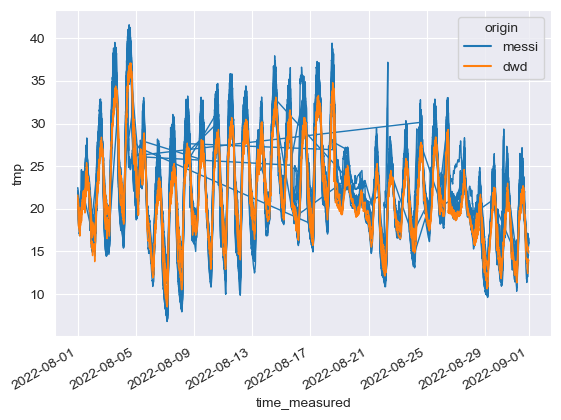

In [80]:
# temperature values
fig, ax = plt.subplots()
sns.lineplot(data=tmp_raw, x="time_measured", y="tmp", hue="origin", units="id", estimator=None, lw=1, ax=ax)
fig.autofmt_xdate()
fig.savefig("../figs/tmp-verlauf.png", dpi=300, bbox_inches="tight")

Die Standorte der DWD-Messstationen und der MESSIs sind dargestellt. Das Hintergrundbild kann mit der entsprechenden `cartopy.io.img_tiles`-Funktion angepasst werden. Soweit sah (leider) Google Maps am besten aus.

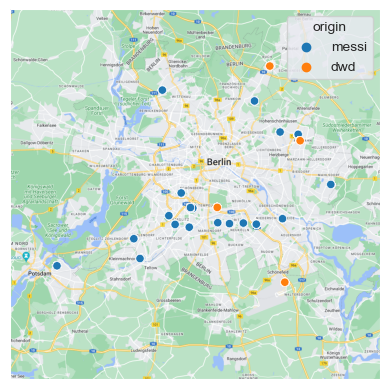

In [81]:
# locations
# https://scitools.org.uk/cartopy/docs/v0.18/cartopy/io/img_tiles.html
# https://docs.dkrz.de/doc/visualization/sw/python/source_code/python-matplotlib-example-high-resolution-background-image-plot.html

trans = ccrs.PlateCarree() # do not change!
request = cimgt.GoogleTiles() # zoom level = 11
#request = cimgt.OSM() # zoom level = 10
#request = cimgt.Stamen(style="toner") # zoom level = 10
#extent = [10, 15, 50, 55]  # (xmin, xmax, ymin, ymax)

fig, ax = plt.subplots(subplot_kw={"projection": request.crs})
ax.add_image(request, 11) 
sns.scatterplot(data=tmp_raw, x="lon", y="lat", hue="origin", transform=trans, ax=ax)
#ax.scatter(tmp_raw.lon, tmp_raw.lat, transform=trans) # faster plotting for debugging

fig.savefig("../figs/locations.png", dpi=300, bbox_inches="tight")
